# KAGGLE Airbnb Challenge

## Owner: **Kai Hong Pang (Samuel) **
## Date Created: May 2020

# HELLO & Before I begin... 

I've been to NYC last spring and I just wanna remind myself what my original intuition for this project is, so that if I keep in mind of what I've done throughout this project. 

##### I think NYC airbnb housing price can be determined by the following features: 

1. Neighbourhood / neighbourhood group
2. Room type (whether it's entire apt, private room....) 
3. Transit
4. Review_score (perhaps take averge of all?) 
5. Amenities

In [62]:
import pandas as pd
import numpy as np 
import re 
import datetime
import matplotlib as plt 
import seaborn as sns
pd.set_option("display.max_columns", 999)
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# HOLD YOUR horses! 
Let's just drop the things that I ABSOLUTELY DON'T NEED

* drop id and other irrelevant features
* drop features who has more than 0.4 proportion of null values 

In [63]:
df = pd.read_csv('train.csv')

In [64]:
df.head(1)

,id,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,host_id,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,country_code,country,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,22267382,Modern and Cozy Large Studio in Brooklyn,Modern large studio with new amenities and app...,Our place is a little quiet sanctuary in the h...,Modern large studio with new amenities and app...,none,"BAM, Barclays, Brooklyn City Point, Fort Green...",NaN,"Subway: 2,3,4,5,A,C,B,Q,G",Washer/Dryer Dishwasher Internet Gym Roof Top ...,"Depending on the time of your visit, I'll be h...","- Please be respectful of our neighbors, no lo...",1910170,Katarina,2012-03-12,"Los Angeles, California, United States","Traveler, Artist, Philanthropist",NaN,NaN,NaN,f,Fort Greene,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Fort Greene,Brooklyn,Brooklyn,NY,11217,New York,US,United States,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Gym,Breakfast...",NaN,145.0,2,$30.00,7,12,6,2018-01-01,2018-07-03,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,flexible,f,f,1,0.59


In [65]:
df = df.drop(['id','host_id','host_name','city','country','country_code','state','experiences_offered',
             'host_acceptance_rate','square_feet','is_business_travel_ready','market','house_rules',
             'summary','name','notes','neighborhood_overview','access','interaction','host_response_time',
             'host_response_rate','host_about','space','zipcode'],axis=1)
df.head(3)

,description,transit,host_since,host_location,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,Modern large studio with new amenities and app...,"Subway: 2,3,4,5,A,C,B,Q,G",2012-03-12,"Los Angeles, California, United States",f,Fort Greene,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,Fort Greene,Brooklyn,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Gym,Breakfast...",145.0,2,$30.00,7,12,6,2018-01-01,2018-07-03,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,flexible,f,f,1,0.59
1,Harlem is back and so gorgeous! Visit and expl...,PUBLIC TRANSPORTATION: Conveniently near all p...,2013-09-14,"New York, New York, United States",f,Mid-Wilshire,4.0,"['email', 'phone', 'reviews', 'manual_offline']",t,t,Harlem,Manhattan,House,Entire home/apt,8,1.0,3.0,5.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",175.0,3,$19.00,3,30,137,2014-04-15,2018-10-20,91.0,9.0,9.0,9.0,9.0,9.0,9.0,t,moderate,f,f,3,2.47
2,"Clean, hip and well designed sun drenched East...",NaN,2012-12-11,"New York, New York, United States",f,East Village,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,East Village,Manhattan,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,""S...",180.0,1,$0.00,2,1125,3,2018-07-26,2018-10-14,100.0,10.0,9.0,9.0,10.0,10.0,10.0,f,moderate,f,f,1,0.89


# Okay, so now I've dropped useless features!

What are some **questionable** features that may not be useful imo?

    * host_has_profile_pic?
    * zipcode?
    * require_guest_profile_picture	
    * require_guest_phone_verification


# Now fix datatypes

In [66]:
# Change BOOLEANS
df.instant_bookable = df.instant_bookable.apply(lambda x:0 if x == 'f' else 1)
df.require_guest_profile_picture = df.require_guest_profile_picture.apply(lambda x:0 if x == 'f' else 1)
df.require_guest_phone_verification = df.require_guest_phone_verification.apply(lambda x:0 if x == 'f' else 1)
df.host_is_superhost = df.host_is_superhost.apply(lambda x:0 if x == 'f' else 1)
df.host_has_profile_pic = df.host_has_profile_pic.apply(lambda x:0 if x == 'f' else 1)
df.host_identity_verified = df.host_identity_verified.apply(lambda x:0 if x == 'f' else 1)

# Change TIMESTAMP
df.first_review = df.first_review.apply(lambda x: pd.Timestamp(x)) 
df.last_review = df.last_review.apply(lambda x: pd.Timestamp(x)) 
df.host_since = df.host_since.apply(lambda x: pd.Timestamp(x)) 

# Strip extra-people
df.extra_people = df.extra_people.apply(lambda x: float(x.strip('$')))

# Now convert all text features to lower case

In [67]:
to_lower = ['description','transit']

for i in range(len(to_lower)):
    df[to_lower[i]] = df[to_lower[i]].str.lower()

In [68]:
df.head(3)

,description,transit,host_since,host_location,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,modern large studio with new amenities and app...,"subway: 2,3,4,5,a,c,b,q,g",2012-03-12,"Los Angeles, California, United States",0,Fort Greene,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,1,Fort Greene,Brooklyn,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Gym,Breakfast...",145.0,2,30.0,7,12,6,2018-01-01,2018-07-03,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,flexible,0,0,1,0.59
1,harlem is back and so gorgeous! visit and expl...,public transportation: conveniently near all p...,2013-09-14,"New York, New York, United States",0,Mid-Wilshire,4.0,"['email', 'phone', 'reviews', 'manual_offline']",1,1,Harlem,Manhattan,House,Entire home/apt,8,1.0,3.0,5.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",175.0,3,19.0,3,30,137,2014-04-15,2018-10-20,91.0,9.0,9.0,9.0,9.0,9.0,9.0,1,moderate,0,0,3,2.47
2,"clean, hip and well designed sun drenched east...",NaN,2012-12-11,"New York, New York, United States",0,East Village,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,East Village,Manhattan,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,""S...",180.0,1,0.0,2,1125,3,2018-07-26,2018-10-14,100.0,10.0,9.0,9.0,10.0,10.0,10.0,0,moderate,0,0,1,0.89


In [69]:
sameN = df['host_neighbourhood'] == df['neighbourhood_cleansed']
df['hostSameN'] = sameN
df['hostSameN'] = df['hostSameN'].apply(lambda x:1 if True else 0)
df.head(3)

,description,transit,host_since,host_location,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,hostSameN
0,modern large studio with new amenities and app...,"subway: 2,3,4,5,a,c,b,q,g",2012-03-12,"Los Angeles, California, United States",0,Fort Greene,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,1,Fort Greene,Brooklyn,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Gym,Breakfast...",145.0,2,30.0,7,12,6,2018-01-01,2018-07-03,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,flexible,0,0,1,0.59,1
1,harlem is back and so gorgeous! visit and expl...,public transportation: conveniently near all p...,2013-09-14,"New York, New York, United States",0,Mid-Wilshire,4.0,"['email', 'phone', 'reviews', 'manual_offline']",1,1,Harlem,Manhattan,House,Entire home/apt,8,1.0,3.0,5.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",175.0,3,19.0,3,30,137,2014-04-15,2018-10-20,91.0,9.0,9.0,9.0,9.0,9.0,9.0,1,moderate,0,0,3,2.47,1
2,"clean, hip and well designed sun drenched east...",NaN,2012-12-11,"New York, New York, United States",0,East Village,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,East Village,Manhattan,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,""S...",180.0,1,0.0,2,1125,3,2018-07-26,2018-10-14,100.0,10.0,9.0,9.0,10.0,10.0,10.0,0,moderate,0,0,1,0.89,1


# One hot encode the following: 

1. Room type 
2. Amenities 
3. Neighbourhood_cleasned 
4. Neighbourhood_group_cleansend 

In [70]:
df.describe()

,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,hostSameN
count,33538.000000,33533.000000,33538.000000,33538.000000,33538.000000,33478.000000,33505.000000,33507.000000,33538.000000,33538.000000,33538.000000,33538.000000,3.353800e+04,33538.000000,25874.000000,25844.000000,25859.000000,25829.000000,25849.000000,25830.000000,25827.000000,33538.000000,33538.000000,33538.000000,33538.000000,26591.000000,33538.0
mean,0.164917,10.006799,0.998062,0.502057,2.856789,1.141376,1.176869,1.571313,145.177291,1.503190,14.232900,6.843074,6.588069e+04,21.635548,93.751488,9.599443,9.255153,9.737466,9.754304,9.500542,9.374647,0.343372,0.024032,0.026865,3.956288,1.429904,1.0
std,0.371112,85.869452,0.043982,0.500003,1.848491,0.425003,0.744365,1.054226,133.085709,1.114226,24.120633,19.781187,1.172732e+07,40.488277,8.315867,0.819684,1.073818,0.706306,0.688775,0.781516,0.888392,0.474841,0.153152,0.161691,12.687366,1.672336,0.0
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.010000,1.0
25%,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,69.000000,1.000000,0.000000,1.000000,2.900000e+01,1.000000,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.000000,0.000000,0.000000,1.000000,0.210000,1.0
50%,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,109.000000,1.000000,0.000000,2.000000,1.124000e+03,5.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,1.000000,0.770000,1.0
75%,0.000000,2.000000,1.000000,1.000000,4.000000,1.000000,1.000000,2.000000,175.000000,2.000000,25.000000,5.000000,1.125000e+03,23.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,0.000000,0.000000,2.000000,2.140000,1.0
max,1.000000,2271.000000,1.000000,1.000000,16.000000,16.500000,10.000000,18.000000,1999.000000,16.000000,300.000000,1250.000000,2.147484e+09,557.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,132.000000,19.890000,1.0


In [71]:
df.head(1)

,description,transit,host_since,host_location,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,hostSameN
0,modern large studio with new amenities and app...,"subway: 2,3,4,5,a,c,b,q,g",2012-03-12,"Los Angeles, California, United States",0,Fort Greene,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,1,Fort Greene,Brooklyn,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Gym,Breakfast...",145.0,2,30.0,7,12,6,2018-01-01,2018-07-03,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,flexible,0,0,1,0.59,1


# Data cleaning done!


Here I will build my baseline model with features on top of page that I thought would be most important: 

1. Neighbourhood / neighbourhood group
2. Room type (whether it's entire apt, private room....) 
3. Transit
4. Review_score (for now I will just the score out of 100, but can consider take averge of all AFTER SCALING later?) 
5. Amenities

For now I will just fit 1,2,4, since I haven't really figured out 3,5 text stuff yet its k u got dis doe


# BUCKLE UP FOR SKLEARN SIMLIM

In [72]:
# import Function transformer packages
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import OrdinalEncoder

# import pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# import model selection packages
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor

# import performance metric packages
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# MODEL GARAGE

In [73]:
df.head(3)

,description,transit,host_since,host_location,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,hostSameN
0,modern large studio with new amenities and app...,"subway: 2,3,4,5,a,c,b,q,g",2012-03-12,"Los Angeles, California, United States",0,Fort Greene,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,1,Fort Greene,Brooklyn,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Gym,Breakfast...",145.0,2,30.0,7,12,6,2018-01-01,2018-07-03,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,flexible,0,0,1,0.59,1
1,harlem is back and so gorgeous! visit and expl...,public transportation: conveniently near all p...,2013-09-14,"New York, New York, United States",0,Mid-Wilshire,4.0,"['email', 'phone', 'reviews', 'manual_offline']",1,1,Harlem,Manhattan,House,Entire home/apt,8,1.0,3.0,5.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",175.0,3,19.0,3,30,137,2014-04-15,2018-10-20,91.0,9.0,9.0,9.0,9.0,9.0,9.0,1,moderate,0,0,3,2.47,1
2,"clean, hip and well designed sun drenched east...",NaN,2012-12-11,"New York, New York, United States",0,East Village,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,East Village,Manhattan,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,"{TV,Wifi,""Air conditioning"",Kitchen,Heating,""S...",180.0,1,0.0,2,1125,3,2018-07-26,2018-10-14,100.0,10.0,9.0,9.0,10.0,10.0,10.0,0,moderate,0,0,1,0.89,1


In [74]:
df.	review_scores_cleanliness	.describe()

count    25859.000000
mean         9.255153
std          1.073818
min          2.000000
25%          9.000000
50%         10.000000
75%         10.000000
max         10.000000
Name: review_scores_cleanliness, dtype: float64

In [75]:
df.description[0]

"modern large studio with new amenities and appliances on the 40th floor in brooklyn, 10 - 15 min from manhattan by subway, all major subways close by, fort greene park, bam, barclay center, great restaurants. washer/dryer available in the unit. gym available in the building at no additional cost our place is a little quiet sanctuary in the heart of fort greene. amazing views from the apartment and common area on the 41st floor. looking for respectful guests, singles/couples, who'll treat this home as theirs. *the studio available is almost identical to the one in pics, but slightly smaller. the rest of the information is the same.that's why we are offering an additional discount. washer/dryer dishwasher internet gym roof top access reception area coffee/tea/light breakfast at the common area depending on the time of your visit, i'll be here to greet you or will leave the keys/instructions with the concierge bam, barclays, brooklyn city point, fort greene park, prospect park, amazing r

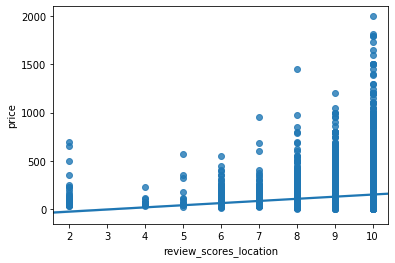

In [76]:
# len(df.description[0].split(' '))

dfC = df.copy()

dfC.description = dfC.description.apply(lambda x:str(x))
dfC.description = dfC.description.apply(lambda x:x.split(' '))
lmao = dfC.description.apply(lambda x:len(x))

# ax = sns.regplot(x=df.review_scores_cleanliness, y=df.price)
ax = sns.regplot(x=df.review_scores_location, y=df.price)


In [77]:
# ax = sns.regplot(x=df.review_scores_value, y=df.price)

In [78]:
# ax = sns.regplot(x=df.review_scores_communication, y=df.price)

In [79]:
# ax = sns.regplot(x=df.review_scores_rating, y=df.price)

# TF-IDF description attempt

# Investigate all the features I have
    * intutively related but actually not that useful? *Evaluate them (Step up? / Grid Search) 
            * xgboost but add one feature at a time 
            
            
    * tune the hyperparamters 
            * increase number of runs in xgboost 
            * 
            
    * try bagging 
            * combine 2/3 models / weighted avg RMSE

In [80]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Using KBEST to select top features

# 1.  tf-ifdf 'description' 

In [81]:
# d_corpus = []
# for i in range(len(df)):
#     d_corpus.append(str(df.description[i]))
# d_corpus

In [82]:
# d_vectorizer = TfidfVectorizer(stop_words = {'00'})
# gg = d_vectorizer.fit_transform(d_corpus)

In [83]:
# d_vectorizer.get_feature_names()

# d_cnt = Counter()
# for word in d_vectorizer.get_feature_names():
#     d_cnt[word] += 1
# d_cnt


In [84]:
# # Select columns 
# lmao = df[['neighbourhood_group_cleansed','neighbourhood_cleansed','room_type','property_type',
#    'number_of_reviews','host_is_superhost','bedrooms','accommodates'
#        ,'bed_type','review_scores_location']].join(top_amen_df)

# # One hot encode 
# lmao = pd.get_dummies(columns=['room_type','neighbourhood_cleansed',
#                               'neighbourhood_group_cleansed','property_type',
#                               'bed_type'],data=lmao)

# # Impute 
# lmao['review_scores_location'] = lmao['review_scores_location'].fillna(value=np.mean(lmao['review_scores_location']))
# lmao.bedrooms = lmao.bedrooms.fillna(value=np.mean(lmao.bedrooms))

# bestfeatures = SelectKBest(score_func=chi2)
# fit = bestfeatures.fit(lmao,df.price)

# Populate KBest table

In [85]:
# bestfeatures = SelectKBest(score_func=f_regression)
# fit = bestfeatures.fit(lmao,df.price)

# dfscores = pd.DataFrame(fit.scores_)
# dfcols = pd.DataFrame(lmao.columns)
# fs = pd.concat([dfcols,dfscores],axis=1)
# fs.columns=['Features','Score']

In [86]:
# fs.nlargest(50,'Score')

In [87]:
# top50_features = fs.nlargest(50,'Score').Features.to_list()

In [88]:
# lmao[top50_features]

In [89]:
# y = df.price
# X_train, X_test, y_train, y_test = train_test_split(lmao, y, test_size=0.20)

# regressor = GradientBoostingRegressor()
# model = regressor.fit(lmao,df.price)

# predict = model.predict(X_test)

# displa
# # print("RMSE of training model is: {}".format((mean_squared_error(y_test, meme_predict, squared=False))))
# # print("RMSE of training model is: " + str(np.mean(RMSE)))

In [90]:
# preds1 = mean_squared_error(y_test, predict, squared=False)
# print(preds1)

In [91]:
df.select_dtypes(include=['object']).head(1)

,description,transit,host_location,host_neighbourhood,host_verifications,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,bed_type,amenities,cancellation_policy
0,modern large studio with new amenities and app...,"subway: 2,3,4,5,a,c,b,q,g","Los Angeles, California, United States",Fort Greene,"['email', 'phone', 'reviews', 'jumio', 'govern...",Fort Greene,Brooklyn,Loft,Entire home/apt,Real Bed,"{Wifi,""Air conditioning"",Kitchen,Gym,Breakfast...",flexible


# APPROACH 3: 

1. Get top 10 numeric features
2. One hot encode 

# Finding most common amenities

In [92]:
from collections import Counter

corpus = ''
for i in range(len(df)):
    corpus += df.amenities[i] 
corpus_words = corpus.split(' ')

cnt = Counter()
for word in corpus_words:
    cnt[word] += 1

del cnt['detector']
del cnt['carbon']
del cnt['monoxide']
del cnt['off']
del cnt['and']
del cnt['on']
del cnt['en.hosting_amenity_49']
del cnt['en.hosting_amenity_50TV']

# display(cnt)

top_amen_counter = cnt.most_common(50)

vocabulary = []
for i in range(len(top_amen_counter)):
    vocabulary.append(top_amen_counter[i][0])
    
print(vocabulary)

['detector","Carbon', 'friendly', 'missing:', 'dryer",Iron,"Laptop', 'bedroom', 'aid', 'detector","First', 'street', 'water","Bed', 'silverware","Cooking', 'parking', 'door",Hangers,"Hair', 'term', 'stays', 'greets', 'pillows', 'en.hosting_amenity_49","translation', 'linens","Extra', 'workspace","translation', 'friendly","Smoke', 'dropoff', 'conditioning",Kitchen,"Free', 'detector","Fire', 'TV",Internet,Wifi,"Air', 'friendly",Washer,Dryer,"Smoke', 'workspace","Self', 'kit","Fire', 'to', 'extinguisher",Essentials,Shampoo,"Lock', 'living', 'intercom",Heating,"Family/kid', 'TV",Wifi,"Air', 'conditioning",Kitchen,"Pets', 'or', 'workspace","Private', 'maker",Refrigerator,"Dishes', 'check-in",Hangers,"Hair', 'allowed","Long', 'kit","Safety', 'card","Fire', 'access","Wide', 'conditioning",Kitchen,"Paid', 'extinguisher",Essentials,Shampoo,Hangers,"Hair', 'path', 'maker",Refrigerator,Dishwasher,"Dishes', 'workspace","Hot', 'dryer","Laptop', 'live', 'this', 'parking",Heating,"Smoke']


In [93]:
#ONE-HOT-ENCODE Amenties 
df.amenities = df.amenities.apply(lambda x: re.sub("^\{","",x))
df.amenities = df.amenities.apply(lambda x: re.sub("}$","",x))
df.amenities = df.amenities.apply(lambda x: re.sub("\"","",x))
df.amenities = df.amenities.apply(lambda x: re.sub("/","",x))
df.amenities = df.amenities.apply(lambda x: re.sub("’n","",x))
df.amenities = df.amenities.apply(lambda x: re.sub(","," ",x))
amen_lst = df.amenities.apply(lambda x: list(x.split(' ')))

# Find most frequent amenities 
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=vocabulary)

mlb_transform = mlb.fit_transform(amen_lst)

all_amen = pd.DataFrame(mlb_transform, columns=mlb.classes_)

top_amen_df = all_amen[vocabulary]
display(top_amen_df)
# display(mlb.classes_)

,"detector"",""Carbon",friendly,missing:,"dryer"",Iron,""Laptop",bedroom,aid,"detector"",""First",street,"water"",""Bed","silverware"",""Cooking",parking,"door"",Hangers,""Hair",term,stays,greets,pillows,"en.hosting_amenity_49"",""translation","linens"",""Extra","workspace"",""translation","friendly"",""Smoke",dropoff,"conditioning"",Kitchen,""Free","detector"",""Fire","TV"",Internet,Wifi,""Air","friendly"",Washer,Dryer,""Smoke","workspace"",""Self","kit"",""Fire",to,"extinguisher"",Essentials,Shampoo,""Lock",living,"intercom"",Heating,""Family/kid","TV"",Wifi,""Air","conditioning"",Kitchen,""Pets",or,"workspace"",""Private","maker"",Refrigerator,""Dishes","check-in"",Hangers,""Hair","allowed"",""Long","kit"",""Safety","card"",""Fire","access"",""Wide","conditioning"",Kitchen,""Paid","extinguisher"",Essentials,Shampoo,Hangers,""Hair",path,"maker"",Refrigerator,Dishwasher,""Dishes","workspace"",""Hot","dryer"",""Laptop",live,this,"parking"",Heating,""Smoke"
0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33534,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33535,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
33536,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [94]:
# from sklearn.feature_extraction.text import TfidfVectorizer


# # vectorizer = TfidfVectorizer(vocabulary=vocabulary)
# # tfidf = vectorizer.fit_transform(corpus)

# # tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
# # tfidf_df

# mlb = MultiLabelBinarizer()
# mlb_result = mlb.fit_transform(corpus)
# # mlb_result.shape
# list(mlb.classes_)

# # tfidf_df = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
# # tfidf_df

In [95]:
num_df = df.select_dtypes(include=['number'])
num_df = num_df.drop('price',axis=1)

# Data Cleaning

In [96]:
num_df.host_listings_count = num_df.host_listings_count.fillna(value=np.mean(num_df.host_listings_count))
num_df.bathrooms = num_df.bathrooms.fillna(value=np.mean(num_df.bathrooms)) 
num_df.bedrooms = num_df.bedrooms.fillna(value=np.mean(num_df.bedrooms)) 
num_df.beds = num_df.beds.fillna(value=np.mean(num_df.beds)) 
num_df.review_scores_rating = num_df.review_scores_rating.fillna(value=np.mean(num_df.review_scores_rating)) 

num_df.review_scores_accuracy = num_df.review_scores_accuracy.fillna(value=np.mean(num_df.review_scores_accuracy)) 
num_df.review_scores_checkin = num_df.review_scores_checkin.fillna(value=np.mean(num_df.review_scores_checkin))
num_df.review_scores_communication = num_df.review_scores_communication.fillna(value=np.mean(num_df.review_scores_communication)) 
num_df.review_scores_value = num_df.review_scores_value.fillna(value=np.mean(num_df.review_scores_value)) 
num_df.reviews_per_month = num_df.reviews_per_month.fillna(value=np.mean(num_df.reviews_per_month))
num_df.review_scores_cleanliness = num_df.review_scores_cleanliness.fillna(value=np.mean(num_df.review_scores_cleanliness))
num_df.review_scores_location = num_df.review_scores_location.fillna(value=np.mean(num_df.review_scores_location)) 


# Feature Selection

In [97]:
bestfeatures = SelectKBest(score_func=f_regression)
fit = bestfeatures.fit(num_df,df.price)

dfscores = pd.DataFrame(fit.scores_)
dfcols = pd.DataFrame(num_df.columns)

fs = pd.concat([dfcols,dfscores],axis=1)
fs.columns=['Features','Score']
# fs.nlargest(50,'Score')

In [98]:
top_10_numeric_features = fs.nlargest(20,'Score').Features.to_list()
top_10_numeric_features 

['accommodates',
 'beds',
 'bedrooms',
 'guests_included',
 'bathrooms',
 'review_scores_location',
 'extra_people',
 'calculated_host_listings_count',
 'host_listings_count',
 'review_scores_cleanliness',
 'review_scores_rating',
 'number_of_reviews',
 'review_scores_value',
 'host_identity_verified',
 'minimum_nights',
 'reviews_per_month',
 'instant_bookable',
 'host_has_profile_pic',
 'host_is_superhost',
 'require_guest_profile_picture']

# Model Building

In [115]:
###################################### SELECT COLUMNS #####################################

X = df[['neighbourhood_group_cleansed',
        'neighbourhood_cleansed',
        'room_type',
        'property_type',
        'review_scores_location',
        'accommodates',
         'beds',
         'bedrooms',
         'guests_included',
         'bathrooms',
         'extra_people',
         'calculated_host_listings_count',
         'host_listings_count',
         'review_scores_cleanliness']]


# Join with tf-df table 
X = X.join(top_amen_df)


###################################### IMPUTE #####################################
X.bedrooms = X.bedrooms.fillna(value = np.mean(X.bedrooms))
X.review_scores_location = X.review_scores_location.fillna(value = np.mean(X.review_scores_location))
X.bathrooms = X.bathrooms.fillna(value=np.mean(X.bathrooms)) 
X.host_listings_count = X.host_listings_count.fillna(value=np.mean(X.host_listings_count))
X.beds = X.beds.fillna(value=np.mean(X.beds)) 
X.review_scores_cleanliness = X.review_scores_cleanliness.fillna(value=np.mean(X.review_scores_cleanliness))


pd.options.display.max_rows = 999
# display(X)

###################################### PIPELINE #####################################

columnTrans = make_column_transformer(
    
    (OneHotEncoder(handle_unknown = 'ignore',sparse=False),
     ['neighbourhood_group_cleansed','neighbourhood_cleansed','room_type','property_type']),
    
    (StandardScaler(), ['review_scores_location',
        'accommodates',
         'beds',
         'bedrooms',
         'guests_included',
         'bathrooms',
         'extra_people',
         'calculated_host_listings_count',
         'host_listings_count',
         'review_scores_cleanliness']),
    remainder = 'passthrough')

###################################### TRAIN TEST SPLIT #####################################
y = df.price 

RMSE = []

# for _ in range(1):

# TRAIN TEST SPLIT 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

###################################### CHOOSE MODEL #####################################
#     model = GradientBoostingRegressor()

# model = linear_model.Lasso(alpha=0.1)

params={
    "learning_rate" : [0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    "max_depth" : [3,4,5,6,10,12,15,17],
    "min_child_weight" : [1,3,5,7,9,11],
    "gamma" : [0,0.1,0.2,0.3,0.4,0.5],
    "colsample_bytree": [0.3,0.4,0.5,0.7]
}

model = xgb.XGBRegressor(min_child_weight= 7,
 max_depth= 12,
 learning_rate= 0.1,
 gamma= 0.4,
 colsample_bytree=0.4)

# model = xgb.XGBRegressor()

###################################### TUNE HYPER_PARAMS #####################################

# Without scaling numeric: 
# {'min_child_weight': 9,
#  'max_depth': 10,
#  'learning_rate': 0.15,
#  'gamma': 0.1,
#  'colsample_bytree': 0.4}

# With scaling numeric: (BEST RUN SO FAR)
# {'min_child_weight': 7,
#  'max_depth': 12,
#  'learning_rate': 0.1,
#  'gamma': 0.4,
#  'colsample_bytree': 0.4}

# LAST RUN DUDE
# {'min_child_weight': 11,
#  'max_depth': 5,
#  'learning_rate': 0.2,
#  'gamma': 0,
#  'colsample_bytree': 0.3}

# 20 features run
# {'min_child_weight': 5,
#  'max_depth': 12,
#  'learning_rate': 0.15,
#  'gamma': 0,
#  'colsample_bytree': 0.5}

random_search = RandomizedSearchCV(model,param_distributions=params,n_iter=5,
                                  scoring="neg_root_mean_squared_error",n_jobs=8,cv=5, verbose=3)

# model = RandomForestRegressor()
# model = SFS(GradientBoostingRegressor(),
#             k_features = 10, 
#             forward = True,
#             floating = False, 
#             verbose = 2,

#             scoring='neg_root_mean_squared_error',
#             cv=5,
#             n_jobs = -1)

pipe = make_pipeline(columnTrans, model)
pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
preds1 = mean_squared_error(y_test, preds, squared=False)
RMSE.append(preds1)

print("RMSE of training model is: {}".format(np.mean(RMSE)))

RMSE of training model is: 82.51599945218905


In [78]:
random_search.best_estimator_

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=0, max_depth=5,
             min_child_weight=11, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [101]:
random_search.best_params_

{'min_child_weight': 5,
 'max_depth': 12,
 'learning_rate': 0.15,
 'gamma': 0,
 'colsample_bytree': 0.5}

# PREDICTING TEST SET

In [116]:
###################################### SELECT COLUMNS #####################################

test_df = pd.read_csv('test.csv')

test_X = test_df[['neighbourhood_group_cleansed',
        'neighbourhood_cleansed',
        'room_type',
        'property_type',
        'review_scores_location',
        'accommodates',
         'beds',
         'bedrooms',
         'guests_included',
         'bathrooms',
         'extra_people',
         'calculated_host_listings_count',
         'host_listings_count',
         'review_scores_cleanliness']]


###################################### TEXT #####################################

test_X.extra_people = test_X.extra_people.apply(lambda x: float(x.strip('$')))

test_df.amenities = test_df.amenities.apply(lambda x: re.sub("^\{","",x))
test_df.amenities = test_df.amenities.apply(lambda x: re.sub("}$","",x))
test_df.amenities = test_df.amenities.apply(lambda x: re.sub("\"","",x))
test_df.amenities = test_df.amenities.apply(lambda x: re.sub("/","",x))
test_df.amenities = test_df.amenities.apply(lambda x: re.sub("’n","",x))
test_df.amenities = test_df.amenities.apply(lambda x: re.sub(","," ",x))
test_df.amenities = test_df.amenities.apply(lambda x: list(x.split(' ')))

###################################### Amenities #####################################

test_mlb_transform = mlb.transform(test_df.amenities)
test_all_amen = pd.DataFrame(test_mlb_transform, columns=mlb.classes_)
test_X = test_X.join(test_all_amen)

###################################### Impute #####################################

test_X.bedrooms = test_X.bedrooms.fillna(value = np.mean(test_X.bedrooms))
test_X.review_scores_location = test_X.review_scores_location.fillna(value = np.mean(test_X.review_scores_location))
test_X.bathrooms = test_X.bathrooms.fillna(value=np.mean(test_X.bathrooms)) 
test_X.host_listings_count = test_X.host_listings_count.fillna(value=np.mean(test_X.host_listings_count))
test_X.beds = test_X.beds.fillna(value=np.mean(test_X.beds)) 
test_X.review_scores_cleanliness = test_X.review_scores_cleanliness.fillna(value=np.mean(test_X.review_scores_cleanliness))

###################################### PREDICT ####################################

preds = pipe.predict(test_X) 
display(preds)


array([389.2063  , 124.63585 ,  60.942375, ..., 107.600174,  53.65482 ,
       119.93487 ], dtype=float32)

In [117]:
######################################################################################
# PREDICT and output csv

test_ids = test_df.id 
output_df = pd.DataFrame()
output_df['Id'] = test_ids
output_df['Predicted'] = preds
output_df.to_csv('kai-baseline.csv', index = False)

# This is NOT the end! What could have been done better next time?


1. More rigorous text feature selection, also accounting for Chinese/Korea airbnb listings 
2. More domain knowledge is better! I just found out there's a Stanford Airbnb prediction paper that's worth reading! 
3. Try use bagging to increase the robustness of my model! 
4. Can I someone incorporate deep learning in the final model? 
5. Honestly I still feel like my feature engineering approach is on the intuition side. Can I somehow make it more logically deterministic?  


# Scratch work

# BASELINE

In [1758]:
def base_model(df, model):

    # PIPELINE
    preproc = ColumnTransformer(transformers = [
                                                ('std',StandardScaler(),['number_of_reviews','review_scores_rating']),
#                                                 ('logdur',FunctionTransformer(np.log1p),['number_0f']), # log scale
#                                                 ('std',StandardScaler(),['review_scores_rating']),
                                                ('hot',OneHotEncoder(handle_unknown = 'ignore'),['neighbourhood_group_cleansed']),
                                                ('hot3',OneHotEncoder(handle_unknown = 'ignore'),['neighbourhood_cleansed']),
                                                ('hot4',OneHotEncoder(handle_unknown = 'ignore'),['room_type']),
                                                ('hot6',OneHotEncoder(handle_unknown = 'ignore'),['bed_type']),
                                                ('hot5',OneHotEncoder(handle_unknown = 'ignore'),['property_type'])]
                                ,remainder = 'passthrough')
    
    pl = Pipeline(steps = [('preprocessor',preproc),('regressor',model)])
    pl.fit(X,y)
    return pl

RMSE = []

for i in range(10):
    # FEATURE SELECTION
    X = df[['neighbourhood_group_cleansed','neighbourhood_cleansed','room_type','property_type',
       'number_of_reviews','review_scores_rating','host_is_superhost','bedrooms','accommodates'
           ,'bed_type']]
    
    # IMPUTATION
    X.review_scores_rating = X.review_scores_rating.fillna(value=np.mean(X.review_scores_rating))
    X.bedrooms = X.bedrooms.fillna(value=0)
#     X.review_scores_rating = X.review_scores_rating.fillna(value=0

    X.host_is_superhost = X.host_is_superhost.apply(lambda x:0 if x == 'f' else 1)
    
    y = df.price 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20)
    train = X_train.join(y_train)
    
    # Choose model and pred
    model = base_model(train, LinearRegression())  
    preds = model.predict(X_test)
    
    # RMSE
    preds1 = mean_squared_error(y_test, preds, squared=False)
    RMSE.append(preds1)
    
print("RMSE of baseline model is: " + str(np.mean(RMSE)))

# Using CV to test

In [1759]:
# from sklearn.linear_model import ElasticNetCV
# RMSE = []

# # FEATURE SELECTION
# X = df[['neighbourhood_group_cleansed','neighbourhood_cleansed','room_type','property_type',
#    'number_of_reviews','review_scores_rating','host_is_superhost','bedrooms','accommodates'
#        ,'bed_type']]

# # Imputation 
# X.review_scores_rating = X.review_scores_rating.fillna(value=np.mean(X.review_scores_rating))
# #     X.review_scores_rating = X.review_scores_rating.fillna(value=0

# X.host_is_superhost = X.host_is_superhost.apply(lambda x:0 if x == 'f' else 1)

# y = df.price 

# models = [LinearRegression(), linear_model.Ridge(alpha=1)]

# for i in models:
#     # Choose model for baseline 
#     model = base_model(train, i)  
#     preds = model.predict(X_test)

#     # Using CV 
#     scores = cross_val_score(model, X, y, cv=10, scoring="neg_root_mean_squared_error")
#     RMSE.append(-scores)

#     print("RMSE of baseline model using CV is: " + str(np.mean(RMSE)))

# EDA

In [1913]:
# def wip_model(df, model):

#     # PIPELINE
#     preproc = ColumnTransformer(transformers = [
#                                                 ('std',StandardScaler(),['number_of_reviews','review_scores_rating']),
#                                                 ('hot',OneHotEncoder(handle_unknown = 'ignore'),['neighbourhood_group_cleansed']),
#                                                 ('hot3',OneHotEncoder(handle_unknown = 'ignore'),['neighbourhood_cleansed']),
#                                                 ('hot4',OneHotEncoder(handle_unknown = 'ignore'),['room_type']),
#                                                 ('hot6',OneHotEncoder(handle_unknown = 'ignore'),['bed_type']),
#                                                 ('hot5',OneHotEncoder(handle_unknown = 'ignore'),['property_type'])]
#                                 ,remainder = 'passthrough')
    
#     # TF-idf pipeline
#     tfidf = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)), 
#                       ('tfid', TfidfTransformer())]).fit(corpus)
    
#     pl = Pipeline(steps = [('preprocessor',preproc),('tfidf',tfidf),('regressor',model)])
    
#     pl.fit(X,y)
#     return pl


In [1914]:
# RMSE = []

# for i in range(5):
#     # FEATURE SELECTION
#     X = df[['neighbourhood_group_cleansed','neighbourhood_cleansed','room_type','property_type',
#        'number_of_reviews','review_scores_rating','host_is_superhost','bedrooms','accommodates'
#            ,'bed_type']]
    
#     # IMPUTATION
#     X.review_scores_rating = X.review_scores_rating.fillna(value=np.mean(X.review_scores_rating))
#     X.bedrooms = X.bedrooms.fillna(value=0)

#     # FIX BOOLEAN
#     X.host_is_superhost = X.host_is_superhost.apply(lambda x:0 if x == 'f' else 1)
    
#     # DECLARE Y variable 
#     y = df.price 
    
#     # TRAIN TEST SPLIT 
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
#     train = X_train.join(y_train)
    
    
    
    
#     # Choose model and pred
# #     model = wip_model(train, LinearRegression())
#     model = wip_model(train, linear_model.Lasso(alpha=0.1))
    
#     # ******** PREDICT **********
#     preds = model.predict(X_test)
    
#     # RMSE
#     preds1 = mean_squared_error(y_test, preds, squared=False)
#     RMSE.append(preds1)
    
# print("RMSE of wip model is: " + str(np.mean(RMSE)))

In [1915]:
# RMSE = []

# for i in range(5):
#     # FEATURE SELECTION
#     X = df[['neighbourhood_group_cleansed','neighbourhood_cleansed','room_type','property_type',
#        'number_of_reviews','review_scores_rating','host_is_superhost','bedrooms','accommodates'
#            ,'bed_type']]
    
#     # IMPUTATION
#     X.review_scores_rating = X.review_scores_rating.fillna(value=np.mean(X.review_scores_rating))
#     X.bedrooms = X.bedrooms.fillna(value=0)

#     # FIX BOOLEAN
#     X.host_is_superhost = X.host_is_superhost.apply(lambda x:0 if x == 'f' else 1)
    
#     # DECLARE Y variable 
#     y = df.price 
    
#     # TRAIN TEST SPLIT 
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
#     train = X_train.join(y_train)
    
#     # Choose model and pred
# #     model = wip_model(train, LinearRegression())
#     model = wip_model(train, linear_model.Lasso(alpha=0.1))
    
#     # ******** PREDICT **********
#     preds = model.predict(X_test)
    
#     # RMSE
#     preds1 = mean_squared_error(y_test, preds, squared=False)
#     RMSE.append(preds1)
    
# print("RMSE of wip model is: " + str(np.mean(RMSE)))

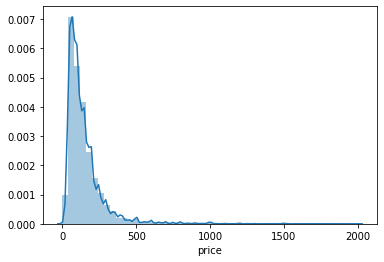

In [1919]:
sns.distplot(df.price)

In [2111]:
# omg = df.	review_scores_cleanliness	.fillna(np.mean())
# sns.distplot(df.	review_scores_cleanliness	)
df.isnull().mean()

description                         0.009184
transit                             0.379927
host_since                          0.000149
host_location                       0.003399
host_is_superhost                   0.000000
host_neighbourhood                  0.140318
host_listings_count                 0.000149
host_verifications                  0.000000
host_has_profile_pic                0.000000
host_identity_verified              0.000000
neighbourhood_cleansed              0.000000
neighbourhood_group_cleansed        0.000000
property_type                       0.000000
room_type                           0.000000
accommodates                        0.000000
bathrooms                           0.001789
bedrooms                            0.000984
beds                                0.000924
bed_type                            0.000000
amenities                           0.000000
price                               0.000000
guests_included                     0.000000
extra_peop

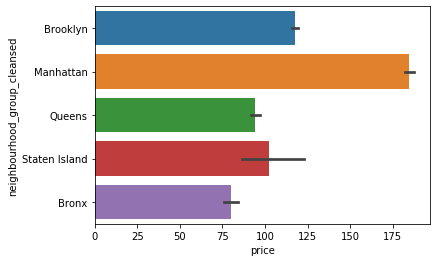

In [1920]:
sns.barplot(y=df.neighbourhood_group_cleansed, x=df.price)

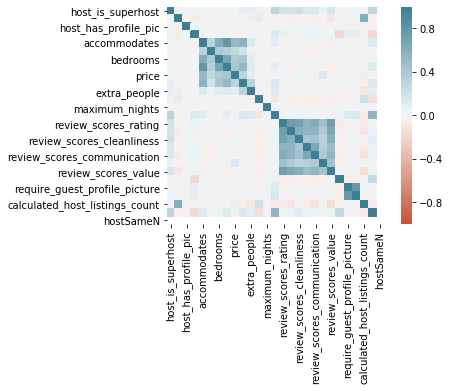

In [1921]:
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

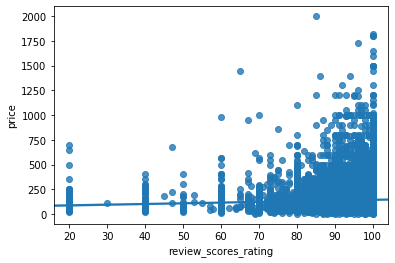

In [1923]:
ax = sns.regplot(x=df.review_scores_rating, y=df.price)

In [2062]:
X.head(2)

,neighbourhood_group_cleansed,neighbourhood_cleansed,room_type,property_type,number_of_reviews,review_scores_rating,host_is_superhost,bedrooms,accommodates,bed_type,friendly,Kitchen,Heating,Essentials,conditioning,Smoke,Air,Wifi,Hangers,Carbon,Hair,Shampoo,Laptop,dryer,Iron,workspace,Hot,parking,allowed,water,Washer,Dryer,missing:,translation,door,Free,Fire,extinguisher,Lock,bedroom,Familykid,check-in,First,aid,kit,street,Elevator,Internet,Buzzerwireless,intercom,TV,Private,Refrigerator,Cable,Dishes,silverware,Bed,linens,Cooking,basics,Oven,Self,Microwave,Pets,Wide,Stove,Coffee,maker,Long,term,stays,greets,Host,premises,entrance,Extra,pillows,Step-free,blankets,access,Luggage,dropoff,Paid,en.hosting_amenity_50,to,24-hour,Safety,card,Lockbox,living,youTV,Dishwasher,or,Gym,Breakfast,doorway,clearance,path,room,live,this,property,workspaceTV,Bathtub,bed,Doorman,Well-lit,OtherTV,Accessible-height,Smoking
0,Manhattan,Battery Park City,Entire home/apt,Condominium,-0.537098,-3.753112e-16,0,2.0,4,Real Bed,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Brooklyn,Bedford-Stuyvesant,Entire home/apt,Apartment,0.018140,3.893148e-01,0,2.0,2,Real Bed,1,1,1,1,1,1,1,1,0,1,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1,1,0,1,1,1,1,0,0,1,0,0,0,1,0


In [2056]:
df

,description,transit,host_since,host_location,host_is_superhost,host_neighbourhood,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,extra_people,minimum_nights,maximum_nights,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,hostSameN
0,modern large studio with new amenities and app...,"subway: 2,3,4,5,a,c,b,q,g",2012-03-12,"Los Angeles, California, United States",0,Fort Greene,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,1,Fort Greene,Brooklyn,Loft,Entire home/apt,2,1.0,1.0,1.0,Real Bed,Wifi Air conditioning Kitchen Gym Breakfast El...,145.0,2,30.0,7,12,6,2018-01-01,2018-07-03,100.0,10.0,10.0,10.0,10.0,10.0,10.0,1,flexible,0,0,1,0.59,1
1,harlem is back and so gorgeous! visit and expl...,public transportation: conveniently near all p...,2013-09-14,"New York, New York, United States",0,Mid-Wilshire,4.0,"['email', 'phone', 'reviews', 'manual_offline']",1,1,Harlem,Manhattan,House,Entire home/apt,8,1.0,3.0,5.0,Real Bed,TV Internet Wifi Air conditioning Kitchen Paid...,175.0,3,19.0,3,30,137,2014-04-15,2018-10-20,91.0,9.0,9.0,9.0,9.0,9.0,9.0,1,moderate,0,0,3,2.47,1
2,"clean, hip and well designed sun drenched east...",NaN,2012-12-11,"New York, New York, United States",0,East Village,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,East Village,Manhattan,Apartment,Entire home/apt,2,1.0,0.0,1.0,Real Bed,TV Wifi Air conditioning Kitchen Heating Smoke...,180.0,1,0.0,2,1125,3,2018-07-26,2018-10-14,100.0,10.0,9.0,9.0,10.0,10.0,10.0,0,moderate,0,0,1,0.89,1
3,"private, spacious, comfortable room in 2-bed f...",NaN,2013-12-03,"New York, New York, United States",0,Williamsburg,1.0,"['email', 'phone', 'reviews', 'kba']",1,1,Williamsburg,Brooklyn,Apartment,Private room,1,1.0,1.0,1.0,Real Bed,Wifi Air conditioning Kitchen Heating Washer D...,42.0,1,0.0,3,1125,0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,flexible,0,0,1,NaN,1
4,"comfy, quiet and big private room in a three b...",super convenient to almost all subway lines. a...,2012-05-11,"Brooklyn, NY",1,Boerum Hill,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",1,1,Boerum Hill,Brooklyn,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,Internet Wifi Air conditioning Kitchen Breakfa...,80.0,1,14.0,1,90,144,2015-01-31,2018-10-17,97.0,10.0,10.0,10.0,10.0,10.0,10.0,0,flexible,0,0,1,3.14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33533,"private room in cozy, sun-drenched & plant fil...",NaN,2012-06-18,"New York, New York, United States",0,Alphabet City,1.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",1,1,East Village,Manhattan,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,TV Internet Wifi Kitchen Heating Shampoo,110.0,1,25.0,3,1125,19,2015-04-13,2016-10-24,87.0,9.0,8.0,9.0,9.0,9.0,8.0,0,strict_14_with_grace_period,0,0,1,0.44,1
33534,this is a beautiful four bedroom and three bat...,apartment is located at 70 w 45th street (betw...,2015-08-21,"Houston, Texas, United States",0,Midtown,3.0,"['email', 'phone', 'reviews', 'kba']",1,1,Theater District,Manhattan,Serviced apartment,Entire home/apt,8,3.0,4.0,4.0,Real Bed,TV Cable TV Internet Wifi Air conditioning Whe...,1195.0,1,0.0,3,365,86,2015-09-28,2018-10-27,95.0,10.0,9.0,10.0,10.0,10.0,9.0,0,strict_14_with_grace_period,0,0,1,2.28,1
33535,room for rent in duplex house located in astor...,NaN,2012-05-03,"New York, New York, United States",0,Astoria,1.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,Woodside